This demo program illustrates how to solve Poisson's equation

\begin{align}
-\boldsymbol{\nabla}^{2}u(\boldsymbol{x}) & =f(\boldsymbol{x}), & \boldsymbol{x}\mbox{ in }\Omega
\end{align}

on the unit square with pure Neumann boundary conditions:

    du/dn(x, y) = -sin(5*x)

and source f given by

    f(x, y) = 10*exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)

Since only Neumann conditions are applied, u is only determined up to
a constant by the above equations. An addition constraint is thus
required, for instance

  $$\int u = 0$$

This is accomplished in this demo by using a Krylov iterative solver
that removes the component in the null space from the solution vector.

In [1]:
from dolfin import *
%matplotlib inline


parameters["linear_algebra_backend"] = "PETSc"

# Create mesh and define function space
mesh = UnitSquareMesh(128, 128)
V = FunctionSpace(mesh, "CG", 1)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)",
               degree=2)
g = Expression("-sin(5*x[0])", degree=2)
a = inner(grad(u), grad(v))*dx
L = f*v*dx + g*v*ds

# Assemble system
A = assemble(a)
b = assemble(L)

# Create vector that spans the null space, and normalize
null_space_vector = b.copy()
null_space_vector[:] = sqrt(1.0/null_space_vector.size())

# Create null space basis object and attach to PETSc matrix
null_space = VectorSpaceBasis([null_space_vector])
as_backend_type(A).set_nullspace(null_space)

# Orthogonalize RHS vector b with respect to the null space (this
# ensures that a solution exists)
null_space.orthogonalize(b)



In [2]:
# Set PETSc solve type (conjugate gradient) and preconditioner
# (algebraic multigrid)
PETScOptions.set("ksp_type", "cg")
PETScOptions.set("pc_type", "ilu")


In [3]:
# Set the solver tolerance
PETScOptions.set("ksp_rtol", 1.0e-8)

# Print PETSc solver configuration
PETScOptions.set("ksp_view")
PETScOptions.set("ksp_monitor")




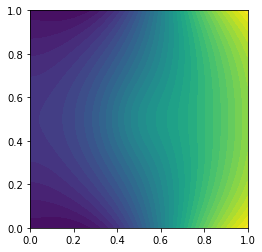

In [4]:
# Create Krylov solver and set operator
solver = PETScKrylovSolver()
solver.set_operator(A)

# Set PETSc options on the solver
solver.set_from_options()

# Create solution Function
u = Function(V)

# Solve
solver.solve(u.vector(), b)

# Plot solution
plot(u, interactive=True)


